### Блок 1. Формулировка задачи

**Датасет:** clf_cat_covertype ("polinaeterna/tabular-benchmark", 'clf_cat_covertype')
https://huggingface.co/datasets/polinaeterna/tabular-benchmark

**Описание:**
- 423680 записи о характеристиках конкретного участка земли в национальном лесе Колорадо, указывающих тип растительного покрова, который на этом участке преобладает.  
- 54 признака: Elevation, Aspect, Slope, Horizontal_Distance_To_Hydrology, Vertical_Distance_To_Hydrology, Horizontal_Distance_To_Roadways, Hillshade_(9am|Noon|3pm), Horizontal_Distance_To_Fire_Points, Wilderness_Area(1..4), Soil_Type(1..40), Cover_Type.  
- Целевая переменная: тип лесного покрова.  

---

## Задача
Предсказать тип лесного покрова (породу доминирующих деревьев) на участке земли в национальном лесе Колорадо (США) на основе картографических и геологических данных. 

- **Тип задачи:** классификация (мультикласс).  
- **Метрики:** Accuracy, `TBD`.  


# Блок 2. Загрузка и первичный осмотр

In [8]:
# ================================================================
# БЛОК 2. ЗАГРУЗКА ДАТАСЕТА И ПЕРВИЧНЫЙ ОСМОТР (Palmer Penguins)
# Цель: загрузить данные, убедиться что они ровные, и сформировать
#       список "ключевых" колонок прозрачно — на основе схемы датасета.
# Да, комментариев много. Это специально: чтобы всё было очевидно.
# ================================================================

# 0) (Если нужно) установка библиотек.
#    У себя для установки можно раскомментировать:
# !pip install -q datasets seaborn pandas matplotlib scikit-learn numpy

# 1) Импорты: datasets — загрузка HF датасетов; pandas — таблицы; seaborn/matplotlib — графики.
from datasets import load_dataset
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 2) Немного косметики для графиков (визуал важен даже у пингвинов).
sns.set_theme(context="talk", style="whitegrid")

In [63]:
# -----------------------------
# ШАГ 1. Загрузить датасет HF.
# -----------------------------
# load_dataset скачает данные в локальный кэш и вернёт DatasetDict со сплитами (train/test и т.п.)
dataset_dict = load_dataset("polinaeterna/tabular-benchmark", 'clf_cat_covertype')

# Выведем краткую сводку по сплитам (сколько строк в каждом).
print("Сплиты и количество объектов:", {split_name: len(dataset_dict[split_name]) for split_name in dataset_dict})

# Покажем схему признаков на уровне HF (до перевода в pandas).
# Это официальный «источник правды» по именам колонок и их типам.
print("\nСхема признаков (HF features):")
print(dataset_dict["train"].features)

# -----------------------------
# ШАГ 2. Перевести train-часть в pandas для удобного EDA.
# -----------------------------
covertype_dataframe = dataset_dict["train"].to_pandas()

# Проверим размер и список колонок.
print("\nРазмер таблицы (строки, колонки):", covertype_dataframe.shape)
print("Колонки:", sorted(covertype_dataframe.columns.tolist()))


Сплиты и количество объектов: {'train': 423680}

Схема признаков (HF features):
{'Elevation': Value('float64'), 'Aspect': Value('float64'), 'Slope': Value('int64'), 'Horizontal_Distance_To_Hydrology': Value('float64'), 'Vertical_Distance_To_Hydrology': Value('float64'), 'Horizontal_Distance_To_Roadways': Value('float64'), 'Hillshade_9am': Value('int64'), 'Hillshade_Noon': Value('int64'), 'Hillshade_3pm': Value('int64'), 'Horizontal_Distance_To_Fire_Points': Value('float64'), 'Wilderness_Area1': Value('int64'), 'Wilderness_Area2': Value('int64'), 'Wilderness_Area3': Value('int64'), 'Wilderness_Area4': Value('int64'), 'Soil_Type1': Value('int64'), 'Soil_Type2': Value('int64'), 'Soil_Type3': Value('int64'), 'Soil_Type4': Value('int64'), 'Soil_Type5': Value('int64'), 'Soil_Type6': Value('int64'), 'Soil_Type7': Value('int64'), 'Soil_Type8': Value('int64'), 'Soil_Type9': Value('int64'), 'Soil_Type10': Value('int64'), 'Soil_Type11': Value('int64'), 'Soil_Type12': Value('int64'), 'Soil_Type13'

In [64]:
# -----------------------------
# ШАГ 3. Сформировать список «ключевых» колонок ПРОЗРАЧНО.
# -----------------------------
# Вопрос «откуда мы знаем названия колонок?» — ответ:
# 1) из документации датасета (ссылочка на HF, там обязаны указывать такую информацию);
# 2) из features, которые мы только что напечатали;
# 3) из нашей задачи: чтобы решить классификацию, нам нужна целевая переменная (species)
#    и набор базовых признаков (числовые и несколько категориальных).

# Ниже мы НЕ "угадываем" имена — мы их строим из схемы (features), а затем
# добавляем проверку, что всё действительно существует в DataFrame.

# Возьмём имена колонок из самой таблицы (это тот же набор, что показали features, но после конверсии в pandas).
all_columns_from_data = set(covertype_dataframe.columns)

# Явно обозначим целевую переменную (её имя точно известно из документации).
target_column = "class"

# Зафиксируем «ключевые» списки — они пригодятся дальше.
# expected_columns = list(all_columns_from_data - {target_column})
feature_columns = list(all_columns_from_data - {target_column})

print("\nЦелевая переменная:", target_column)
print("Признаки (feature_columns):", feature_columns)

# -----------------------------
# ШАГ 4. Показать первые строки «живых» данных.
# -----------------------------
# Зачем: визуально убедиться, что значения выглядят правдоподобно (без тысяч запятых, без странных кодов).
covertype_dataframe.head()



Целевая переменная: class
Признаки (feature_columns): ['Soil_Type21', 'Soil_Type3', 'Soil_Type25', 'Soil_Type24', 'Soil_Type28', 'Soil_Type4', 'Soil_Type32', 'Soil_Type8', 'Soil_Type11', 'Soil_Type40', 'Soil_Type7', 'Soil_Type5', 'Soil_Type14', 'Soil_Type18', 'Soil_Type26', 'Soil_Type15', 'Soil_Type27', 'Soil_Type23', 'Soil_Type33', 'Hillshade_9am', 'Hillshade_3pm', 'Soil_Type19', 'Horizontal_Distance_To_Fire_Points', 'Soil_Type38', 'Soil_Type39', 'Soil_Type20', 'Soil_Type1', 'Slope', 'Soil_Type16', 'Horizontal_Distance_To_Roadways', 'Soil_Type22', 'Elevation', 'Soil_Type35', 'Soil_Type30', 'Soil_Type37', 'Soil_Type9', 'Soil_Type29', 'Wilderness_Area4', 'Soil_Type31', 'Wilderness_Area2', 'Horizontal_Distance_To_Hydrology', 'Soil_Type36', 'Aspect', 'Wilderness_Area3', 'Soil_Type6', 'Vertical_Distance_To_Hydrology', 'Hillshade_Noon', 'Soil_Type34', 'Soil_Type10', 'Soil_Type17', 'Soil_Type12', 'Wilderness_Area1', 'Soil_Type2', 'Soil_Type13']


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,class
0,3156.0,45.0,15,212.0,39.0,5208.0,223,207,115,2925.0,...,0,0,0,0,0,0,0,0,0,1
1,3164.0,346.0,2,295.0,33.0,3114.0,215,235,158,934.0,...,0,0,0,0,0,0,0,0,0,1
2,2839.0,136.0,13,190.0,28.0,3000.0,240,235,122,2122.0,...,0,0,0,0,0,0,0,0,0,1
3,2924.0,324.0,14,60.0,11.0,4699.0,183,224,180,2279.0,...,0,0,0,0,0,0,0,0,0,1
4,3090.0,45.0,22,430.0,20.0,4108.0,220,188,92,3165.0,...,0,0,0,0,0,0,0,0,0,1


# Блок 3. Первичная диагностика данных (EDA light)

Перед тем как строить модель, важно понять, что у нас за данные и в каком они состоянии.  

---

### 1. Проверка пропусков
- В данных встречаются **NaN** — это значит, что какое-то значение не было измерено.  
- Это не баг, а нормальная ситуация в реальных исследованиях.  
- Модели scikit-learn напрямую работать с NaN не умеют → придётся потом решать, как их обрабатывать.




### 2. Типы признаков
- **Числовые признаки**: `Elevation`, `Aspect`, `Slope`, `Distance`, `Hillshade`.

- **Категориальные признаки**: `Wilderness_Area`, `Soil_Type`.

---

### 3. Базовая статистика
- Проверяем минимумы, максимумы, средние значения.  
- Если высота над уровнем моря 30 000 м — это подозрительно, стоит проверить.  
- Смотрим, нет ли выбросов и странных значений.

---

### 4. Баланс классов (species)
- Если один вид встречается гораздо чаще других → простая модель может «читерить», всегда предсказывать его и получать высокий accuracy.  
- Поэтому нам нужны более адекватные метрики, например F1 или ROC-AUC.

---

### 5. Визуализация
- Scatterplot (например, длина vs глубина клюва) показывает, можно ли вообще разделять виды по признакам.  
- На графиках видно, что виды пингвинов реально образуют группы.  
- Это хороший знак: задача классификации имеет смысл.


In [65]:
# ================================================================
# БЛОК 3. ПЕРВИЧНАЯ ДИАГНОСТИКА ДАННЫХ
# Цель: проверить качество данных перед построением моделей.
# ================================================================

# === ШАГ 1. Проверка пропусков (NaN) ===
# .isna() помечает все пропущенные значения, .sum() считает их количество.
print("Количество пропусков в каждой колонке:\n")
print(covertype_dataframe.isna().sum())

# Важно: модели scikit-learn напрямую работать с NaN не умеют.
# Если не обработать пропуски, обучение упадёт с ошибкой.

Количество пропусков в каждой колонке:

Elevation                             0
Aspect                                0
Slope                                 0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Roadways       0
Hillshade_9am                         0
Hillshade_Noon                        0
Hillshade_3pm                         0
Horizontal_Distance_To_Fire_Points    0
Wilderness_Area1                      0
Wilderness_Area2                      0
Wilderness_Area3                      0
Wilderness_Area4                      0
Soil_Type1                            0
Soil_Type2                            0
Soil_Type3                            0
Soil_Type4                            0
Soil_Type5                            0
Soil_Type6                            0
Soil_Type7                            0
Soil_Type8                            0
Soil_Type9                            0
Soil_Type10                           0


In [66]:
# === ШАГ 2. Разделим признаки по типам ===
# Числовые и категориальные признаки обычно обрабатываются по-разному.
numeric_columns = covertype_dataframe.select_dtypes(include="number").columns.tolist()
categorical_columns = covertype_dataframe.select_dtypes(exclude="number").columns.tolist()

print("\nЧисловые признаки:", numeric_columns)
print("Категориальные признаки:", categorical_columns)

# === ШАГ 3. Базовая статистика по числовым признакам ===
# .describe() считает набор стандартных статистик для каждого числового признака:
# count, mean, std, min, 25%, 50% (медиана), 75%, max.
#
# Это встроенный метод pandas, и именно он создаёт колонки с названиями "mean", "std", "min", "max".
# Мы НЕ придумываем их сами — они уже есть в результате describe().
#
# После этого:
# - .T (transpose) меняет местами строки и колонки → теперь строки = признаки, колонки = статистики.
# - [["mean", "std", "min", "max"]] оставляем только эти четыре колонки.
# - .round(2) округляет до двух знаков для красоты.

stats_table = (
    covertype_dataframe[numeric_columns]
    .describe()
    .T[["mean", "std", "min", "max"]]
    .round(2)
)

# Чтобы было понятнее, продублируем перевод колонок на русский.
stats_table = stats_table.rename(
    columns={
        "mean": "mean (среднее)",
        "std": "std (стандартное отклонение)",
        "min": "min (минимум)",
        "max": "max (максимум)"
    }
)

print("\nОписание числовых признаков:\n")
stats_table



Числовые признаки: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40', 'class']
Категориальные признаки: []

Описание числовых признаков:



,mean (среднее),std (стандартное отклонение),min (минимум),max (максимум)
Elevation,3024.77,201.62,2142.0,3686.0
Aspect,154.08,112.27,0.0,360.0
Slope,13.33,6.97,0.0,66.0
Horizontal_Distance_To_Hydrology,275.08,213.44,0.0,1390.0
Vertical_Distance_To_Hydrology,44.00,57.04,-166.0,598.0
Horizontal_Distance_To_Roadways,2521.06,1562.52,0.0,7117.0
Hillshade_9am,212.93,24.89,0.0,254.0
Hillshade_Noon,224.37,18.37,0.0,254.0
Hillshade_3pm,143.42,36.14,0.0,254.0
Horizontal_Distance_To_Fire_Points,2087.91,1334.92,0.0,7172.0



Распределение классов (class):

class
1    0.5
2    0.5
Name: proportion, dtype: float64


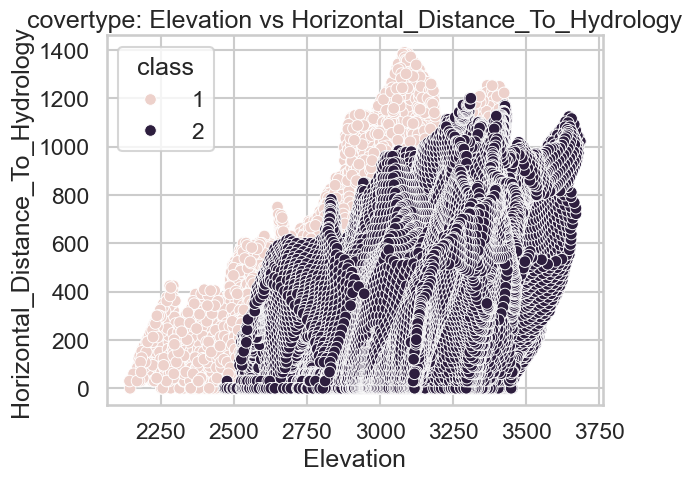

In [67]:
# === ШАГ 4. Распределение целевой переменной (class) ===
# .value_counts() считает количество объектов каждого класса.
# Параметр normalize=True возвращает доли (а не абсолютные числа).
# .round(3) округляет до 3 знаков после запятой.
print(f"\nРаспределение классов ({target_column}):\n")
print(covertype_dataframe[target_column].value_counts(normalize=True).round(3))

# TODO: edit comments ^^^vvv

# Зачем смотреть?
# - Если один класс сильно перевешивает остальные, модель может "читерить":
#   всегда предсказывать самый популярный класс и получать высокую точность (accuracy).
# - Например, если 70% пингвинов = Adelie, модель с accuracy=0.7 может просто
#   всегда отвечать "Adelie" и казаться "умной".
# - Поэтому нужно заранее знать баланс классов и выбирать адекватные метрики
#   (например, F1-score, ROC-AUC), а не слепо доверять accuracy.

# === ШАГ 5. Визуальная проверка разделимости (bill_length vs bill_depth) ===
# Строим scatterplot: каждая точка = один пингвин.
# - по оси X: длина клюва (bill_length_mm),
# - по оси Y: глубина клюва (bill_depth_mm),
# - цвет точки: вид пингвина (species).
sns.scatterplot(
    data=covertype_dataframe,
    x="Elevation",
    y="Horizontal_Distance_To_Hydrology",
    hue=target_column, # покрасим точки, чтобы понимать какой класс
    s=70   # размер точек
)
plt.title("covertype: Elevation vs Horizontal_Distance_To_Hydrology")
plt.show()

# Что видно:
# - Виды образуют группы (кластеры).
# - Например, представители 1-го класса располагаются ниже, но могут находиться дальше от воды.
# - Это значит, что признаки реально помогают разделять классы → задача ML осмысленна.


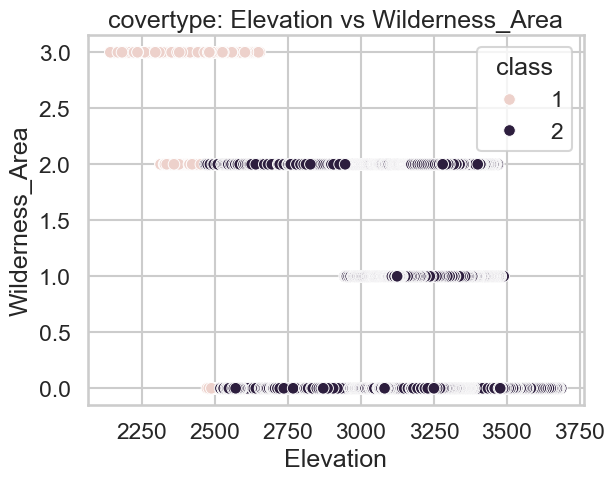

In [68]:
# === ШАГ 6. Визуальная проверка (Elevation vs Wilderness_Area) ===
# Ещё один scatterplot:
# - по оси X: высота над уровнем моря (Elevation),
# - по оси Y: зона природы (Wilderness_Area),
# - цвет = тип леса.

# Объединяем one-hot encoded признаки в один
wilderness_cols = ['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4']
df = covertype_dataframe.copy(deep=True)
df['Wilderness_Area'] = df[wilderness_cols].idxmax(axis=1)
df['Wilderness_Area'] = df['Wilderness_Area'].str.replace('Wilderness_Area', '').astype(int) - 1
df = df.drop(columns=wilderness_cols)

dataframe_with_merged_columns = df

sns.scatterplot(
    data=dataframe_with_merged_columns,
    x="Elevation",
    y="Wilderness_Area",
    hue=target_column,
    s=70
)
plt.title("covertype: Elevation vs Wilderness_Area")
plt.show()


# TODO: edit comments vvv

# Что видно:
# - на почве третьего типа представлены во основном леса 1 типа
# - леса 2 типа располагаются ниже на каждом виде почвы

# Блок 4. Подготовка данных

Перед тем как строить модель, нужно привести данные в порядок.  
Если пропустить этот этап, модель может упасть с ошибкой или научиться на «кривых» данных.

---

### 1. Пропуски (NaN) 
- Машинное обучение напрямую не умеет работать с NaN → надо что-то с ними делать.  
- Возможные стратегии:
  - **Удалить строки** с пропусками (просто, но мы теряем данные).  
  - **Заполнить значения**:
    - для числовых признаков: среднее или медиана;  
    - для категориальных: самое частое значение (мода).  
- Для обучения мы чаще используем заполнение (`imputation`), чтобы не терять данные.

---

### 2. Разделение на признаки и целевую переменную
- **Признаки (X)** — это всё, по чему модель делает выводы (числа и категории).  
- **Целевая переменная (y)** — это то, что мы хотим предсказать.  

⚠️ Важно: если целевая переменная случайно попадёт в X, модель будет «подсматривать в ответ» и выдавать идеальные предсказания на тренировке.  
На самом деле она ничему не научится и провалится на новых данных.  

---

### 3. Разбиение на обучающую и тестовую выборки
- **Train (обучающая часть)**: модель на ней учится.  
- **Test (тестовая часть)**: модель видит её впервые, мы проверяем качество.  

---

### 4. Категориальные признаки
- Пока они остаются как текстовые (`island`, `sex`).  
- Мы научимся кодировать их в числовой вид (One-Hot Encoding).  
- Это нужно, потому что большинство моделей умеют работать только с числами.

---

### Цель этого блока
Сделать аккуратный набор данных:  
- без пропусков,  
- с понятным разделением X/y,  
- с train/test split.  


In [69]:
# ================================================================
# БЛОК 4. ПОДГОТОВКА ДАННЫХ ПЕРЕД ОБУЧЕНИЕМ МОДЕЛИ
# Цели:
# 1) Обработать пропуски (NaN), чтобы модели не падали.
# 2) Явно отделить признаки (X) и целевую переменную (y).
# 3) Разбить данные на train / test с сохранением баланса классов.
# ================================================================

# Для удобства разделим признаки на числовые и категориальные
features_numeric_columns = (
    covertype_dataframe[feature_columns]
    .select_dtypes(include="number")
    .columns
    .tolist()
)
features_categorical_columns = (
    covertype_dataframe[feature_columns]
    .select_dtypes(exclude="number")
    .columns
    .tolist()
)

print("Целевая переменная:", target_column)
print("Признаки:", feature_columns)
print("\nЧисловые признаки:", features_numeric_columns)
print("Категориальные признаки:", features_categorical_columns)

# --- ШАГ 1. Посмотрим, где именно пропуски (NaN) ---
print("\nКоличество пропусков ДО обработки (по колонкам):\n")
print(covertype_dataframe[feature_columns + [target_column]].isna().sum())

# ------------------------------------------------
# Вариант A. Удалить строки с пропусками
# ------------------------------------------------
prepared_dataframe_dropna = covertype_dataframe[feature_columns + [target_column]].dropna(axis=0).copy()

print("\nВариант A — после dropna:")
print("Размер:", prepared_dataframe_dropna.shape)
print("Осталось пропусков:", int(prepared_dataframe_dropna.isna().sum().sum()))

# ------------------------------------------------
# Вариант B. Заполнить пропуски (импутация)
# ------------------------------------------------
# Идея: вместо того, чтобы терять строки, аккуратно подставим значения.
# Для числовых колонок используем МЕДИАНУ, для категориальных — МОДУ.

prepared_dataframe_imputed = covertype_dataframe[feature_columns + [target_column]].copy()

# 1) Числовые колонки → медиана
# Медиана = "середина" распределения.
# - Устойчива к выбросам: если у одного пингвина вдруг масса 30000 г, среднее "сломается",
#   а медиана почти не изменится.
# - Хорошо подходит для заполнения дыр в данных измерений.
for numeric_name in features_numeric_columns:
    median_value = prepared_dataframe_imputed[numeric_name].median()
    prepared_dataframe_imputed[numeric_name] = prepared_dataframe_imputed[numeric_name].fillna(median_value)

# 2) Категориальные колонки → мода
# Мода = самое частое значение в колонке.
# - Для пола (sex) это, например, "male" или "female" — подставим тот вариант,
#   который встречается чаще всего.
# - Это разумно, потому что мы "угадываем" пропущенное значение по статистике большинства.
for categorical_name in features_categorical_columns:
    most_frequent_values = prepared_dataframe_imputed[categorical_name].mode(dropna=True)
    if len(most_frequent_values) > 0:
        prepared_dataframe_imputed[categorical_name] = prepared_dataframe_imputed[categorical_name].fillna(most_frequent_values.iloc[0])

print("\nВариант B — после импутации:")
print("Размер:", prepared_dataframe_imputed.shape)
print("Осталось пропусков:", int(prepared_dataframe_imputed.isna().sum().sum()))


Целевая переменная: class
Признаки: ['Soil_Type21', 'Soil_Type3', 'Soil_Type25', 'Soil_Type24', 'Soil_Type28', 'Soil_Type4', 'Soil_Type32', 'Soil_Type8', 'Soil_Type11', 'Soil_Type40', 'Soil_Type7', 'Soil_Type5', 'Soil_Type14', 'Soil_Type18', 'Soil_Type26', 'Soil_Type15', 'Soil_Type27', 'Soil_Type23', 'Soil_Type33', 'Hillshade_9am', 'Hillshade_3pm', 'Soil_Type19', 'Horizontal_Distance_To_Fire_Points', 'Soil_Type38', 'Soil_Type39', 'Soil_Type20', 'Soil_Type1', 'Slope', 'Soil_Type16', 'Horizontal_Distance_To_Roadways', 'Soil_Type22', 'Elevation', 'Soil_Type35', 'Soil_Type30', 'Soil_Type37', 'Soil_Type9', 'Soil_Type29', 'Wilderness_Area4', 'Soil_Type31', 'Wilderness_Area2', 'Horizontal_Distance_To_Hydrology', 'Soil_Type36', 'Aspect', 'Wilderness_Area3', 'Soil_Type6', 'Vertical_Distance_To_Hydrology', 'Hillshade_Noon', 'Soil_Type34', 'Soil_Type10', 'Soil_Type17', 'Soil_Type12', 'Wilderness_Area1', 'Soil_Type2', 'Soil_Type13']

Числовые признаки: ['Soil_Type21', 'Soil_Type3', 'Soil_Type25', 

In [70]:
# ------------------------------------------------
# Выбираем вариант для дальнейшей работы
# ------------------------------------------------
# В датасете нет пропусков, поэтому варианты идентичны
prepared_dataframe = prepared_dataframe_dropna

# --- ШАГ 2. Отделяем признаки (X) и целевую переменную (y) ---
# X = всё, по чему будем предсказывать (features).
# y = то, что предсказываем (target).
features_matrix = prepared_dataframe[feature_columns].copy()   # Матрица признаков (таблица без target)
target_vector = prepared_dataframe[target_column].copy()       # Вектор ответов (целевой столбец)

print("\nПроверка X / y:")
print("Форма X:", features_matrix.shape)  # (строки, признаки)
print("Форма y:", target_vector.shape)    # (строки,)

# --- ШАГ 3. Разбиваем на train/test ---
# train_test_split — стандартная функция sklearn для разделения данных.
from sklearn.model_selection import train_test_split

features_train, features_test, target_train, target_test = train_test_split(
    features_matrix,       # все признаки (X)
    target_vector,         # целевая переменная (y)
    test_size=0.3,         # 30% в тестовую выборку, 70% в обучающую
    stratify=target_vector, # сохраняем баланс классов (доли видов пингвинов будут те же)
    random_state=42        # фиксируем "случайность", чтобы у всех получился одинаковый split (Воспроизводимость экспериментов очень важна)
)

print("\nTrain/Test split выполнен.")
print("X_train:", features_train.shape, " | X_test:", features_test.shape)
print("y_train:", target_train.shape, " | y_test:", target_test.shape)

# Проверим баланс классов
print("\nБаланс классов в y_train:")
print(target_train.value_counts(normalize=True).round(3))
print("\nБаланс классов в y_test:")
print(target_test.value_counts(normalize=True).round(3))


Проверка X / y:
Форма X: (423680, 54)
Форма y: (423680,)

Train/Test split выполнен.
X_train: (296576, 54)  | X_test: (127104, 54)
y_train: (296576,)  | y_test: (127104,)

Баланс классов в y_train:
class
2    0.5
1    0.5
Name: proportion, dtype: float64

Баланс классов в y_test:
class
2    0.5
1    0.5
Name: proportion, dtype: float64


# Блок 5. Кодирование категориальных признаков и базовая модель

---

### 1. Зачем кодировать категориальные признаки?
- Многие модели машинного обучения умеют работать только с числами.  
- Текстовые признаки (`island`, `sex`) нужно преобразовать в числовой вид.  

---

### 2. One-Hot Encoding
- Метод, при котором каждое уникальное значение категории превращается в отдельную колонку.  
- В колонке ставим `1`, если объект принадлежит категории, иначе `0`.  

**Пример для признака `sex`:**

| sex     | sex_male | sex_female |
|---------|----------|------------|
| male    | 1        | 0          |
| female  | 0        | 1          |
| male    | 1        | 0          |

**Пример для признака `island` (3 значения):**

| island   | island_Biscoe | island_Dream | island_Torgersen |
|----------|---------------|---------------|------------------|
| Biscoe   | 1             | 0             | 0                |
| Dream    | 0             | 1             | 0                |
| Torgersen| 0             | 0             | 1                |

Такое разбиение:
- сохраняет смысл категориального признака;  
- не даёт модели «думать», что одна категория больше или меньше другой (как при кодировке `male=0, female=1`).  

---

### 3. Зачем скейлить числовые признаки?
- Числовые признаки могут быть в разных единицах:
  - длина клюва ~ 40 мм,  
  - масса тела ~ 4000 г.  
- Если их оставить как есть, модель может считать, что «масса важнее длины клюва», 
  просто потому что числа больше.  

---

**Формула StandardScaler:**

$$
z = \frac{x - \mu}{\sigma}
$$

- $x$ — исходное значение  
- $\mu$ — среднее по признаку  
- $\sigma$ — стандартное отклонение признака

---

**Пример:**  
Возьмём признак с тремя значениями: [2, 4, 6].  

- Среднее: $\mu = 4$  
- Стандартное отклонение: $\sigma = 2$  

Применяем формулу:  

- Для $x=2$: $\; z = \dfrac{2 - 4}{2} = -1$  
- Для $x=4$: $\; z = \dfrac{4 - 4}{2} = 0$  
- Для $x=6$: $\; z = \dfrac{6 - 4}{2} = +1$  

---

**Итог:**  
- Новые значения: $[-1, 0, +1]$  
- Среднее стало $0$  
- Разброс (стандартное отклонение) стал $1$  

---

**Что это даёт?**
- Все признаки оказываются «в одной системе координат».  
- Логистическая регрессия и другие линейные модели работают стабильнее.  
- Признаки с большими числами перестают «перетягивать» внимание модели.


### 4. Базовая модель
- Начнём с **логистической регрессии**:
  - простая, прозрачная модель;  
  - подходит для классификации;  
  - даёт хороший бейзлайн (точку отсчёта).  

---

### 5. Что делаем в этом блоке
1. Кодируем категориальные признаки (One-Hot).  
2. Масштабируем числовые признаки (StandardScaler).  
3. Собираем всё в единый **Pipeline** вместе с моделью.  
4. Обучаем на тренировочной выборке и проверяем качество на тестовой.


In [71]:
from sklearn.preprocessing import StandardScaler

# Возьмём один числовой признак для примера
original_values = covertype_dataframe[["Elevation"]].dropna().values  # уберём NaN

print("До скейлинга:")
print("Среднее =", round(original_values.mean(), 2))
print("Стандартное отклонение =", round(original_values.std(), 2))
print("Примеры значений:", original_values[:5].flatten())

# Применим StandardScaler
scaler = StandardScaler()
scaled_values = scaler.fit_transform(original_values)

print("\nПосле скейлинга:")
print("Среднее ≈", round(scaled_values.mean(), 2))   # должно быть ~0
print("Стандартное отклонение ≈", round(scaled_values.std(), 2))  # должно быть ~1
print("Примеры значений:", scaled_values[:5].flatten().round(2))


До скейлинга:
Среднее = 3024.77
Стандартное отклонение = 201.62
Примеры значений: [3156. 3164. 2839. 2924. 3090.]

После скейлинга:
Среднее ≈ 0.0
Стандартное отклонение ≈ 1.0
Примеры значений: [ 0.65  0.69 -0.92 -0.5   0.32]


In [72]:
# ================================================================
# БЛОК 5. КОДИРОВАНИЕ КАТЕГОРИЙ + СКЕЙЛИНГ ЧИСЕЛ + БАЗОВАЯ МОДЕЛЬ
# Что делаем:
#  - превращаем текстовые признаки в числа (One-Hot Encoding),
#  - приводим числовые признаки к единому масштабу (StandardScaler),
#  - объединяем всё в единый Pipeline,
#  - обучаем логистическую регрессию на train и оцениваем на test.
# ================================================================

# Импорты для препроцессинга, пайплайна и модели
from sklearn.preprocessing import StandardScaler, OneHotEncoder          # скейлинг чисел и кодирование категорий
from sklearn.compose import ColumnTransformer                            # применить разные трансформеры к разным колонкам
from sklearn.pipeline import Pipeline                                     # объединить шаги в одну «трубу»
from sklearn.linear_model import LogisticRegression                       # базовая модель классификации
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# ШАГ 1. Описываем, как преобразовать признаки
# -----------------------------
# Для ЧИСЛОВЫХ признаков будем использовать StandardScaler:
#  - вычитает среднее и делит на стандартное отклонение;
#  - у каждого числового признака после трансформации mean≈0 и std≈1;
#  - это помогает алгоритмам, чувствительным к масштабу (логистическая регрессия, kNN и др.).
numeric_transformer = StandardScaler()

# Для КАТЕГОРИАЛЬНЫХ признаков используем OneHotEncoder:
#  - каждое уникальное значение превращается в отдельную бинарную колонку (0/1);
#  - handle_unknown='ignore' — если на тесте встретится новая категория, не падать (просто игнорировать её);
#  - параметр sparse:
#      * в новых версиях sklearn используется аргумент sparse_output=False;
#      * здесь оставим по умолчанию (разреженная матрица), чтобы избежать предупреждений о версиях.
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

# ColumnTransformer позволяет назначить:
#  - какие колонки обрабатывает numeric_transformer,
#  - какие — categorical_transformer,
#  - что делать с остальными (remainder='drop' — отбросить).
preprocessor = ColumnTransformer(
    transformers=[
        ("scale_numeric", numeric_transformer, features_numeric_columns),         # имя шага, трансформер, список колонок
        ("onehot_categorical", categorical_transformer, features_categorical_columns),
    ],
    remainder="drop"                                                              # других колонок у нас и не должно быть
)

In [73]:
# ================================================================
# БЛОК 5. ОБУЧЕНИЕ И ПРОВЕРКА БАЗОВОЙ МОДЕЛИ (Logistic Regression)
# ================================================================

# -----------------------------
# ШАГ 2. Собираем единый Pipeline: препроцессинг → модель
# -----------------------------
# Модель: Логистическая регрессия (подходит для многоклассовой классификации).
# Параметры:
#   - max_iter=1000: даём оптимизатору больше итераций, чтобы точно сходился;
#   - solver="lbfgs": устойчивый алгоритм оптимизации, хорошо работает для многоклассовых задач.
from sklearn.linear_model import LogisticRegression
classification_model = LogisticRegression(max_iter=1000, solver="lbfgs")

# Pipeline («конвейер»): объединяем шаги в одну «трубу».
# 1) preprocess: сначала выполняем подготовку данных (StandardScaler для числовых + OneHotEncoder для категориальных)
# 2) clf: затем обучаем классификатор (логистическую регрессию)
from sklearn.pipeline import Pipeline
full_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),   # шаг 1: трансформация признаков (учится ТОЛЬКО на train)
        ("clf", classification_model)   # шаг 2: модель (учится на выходе из шага 1)
    ]
)

# -----------------------------
# ШАГ 3. Обучаемся на TRAIN, проверяемся на TEST
# -----------------------------
# .fit(): одновременно подгоняет трансформеры (скейлер и OHE) и обучает модель на преобразованных train-данных.
full_pipeline.fit(features_train, target_train)

# .predict(): применяет те же самые трансформации к test-данным и выдаёт предсказания классов.
test_predictions = full_pipeline.predict(features_test)

# Считаем базовые метрики качества:
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Accuracy = доля верно предсказанных объектов
test_accuracy = accuracy_score(target_test, test_predictions)

# F1-macro = среднее F1 по всем классам (важно, если классы несбалансированы)
test_f1_macro = f1_score(target_test, test_predictions, average="macro")

print("\n=== БАЗОВЫЙ РЕЗУЛЬТАТ НА TEST ===")
print("Accuracy (test):", round(test_accuracy, 3))
print("F1-macro (test):", round(test_f1_macro, 3))

# -----------------------------
# ШАГ 4. Детальный отчёт по классам
# -----------------------------
# classification_report показывает precision, recall, f1-score и support для каждого класса отдельно,
# а также сводные метрики (accuracy, macro avg, weighted avg).
print("\nОтчёт по классам (classification_report):\n")
print(classification_report(target_test, test_predictions, digits=3))



=== БАЗОВЫЙ РЕЗУЛЬТАТ НА TEST ===
Accuracy (test): 0.773
F1-macro (test): 0.773

Отчёт по классам (classification_report):

              precision    recall  f1-score   support

           1      0.777     0.766     0.772     63552
           2      0.769     0.780     0.775     63552

    accuracy                          0.773    127104
   macro avg      0.773     0.773     0.773    127104
weighted avg      0.773     0.773     0.773    127104



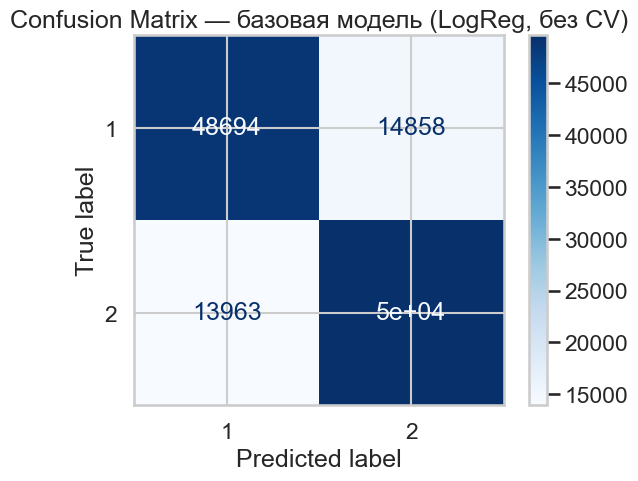

In [74]:
# -----------------------------
# ШАГ 4. Визуальный контроль: матрица ошибок (confusion matrix)
# -----------------------------
# Показывает, какие классы модель путает между собой.
ConfusionMatrixDisplay.from_predictions(target_test, test_predictions, cmap="Blues")
plt.title("Confusion Matrix — базовая модель (LogReg, без CV)")
plt.show()



# Дополнительный эксперимент: kNN (k-ближайших соседей)

Мы заменим модель логистической регрессии на kNN и сравним результаты.

### Идея алгоритма:
- Чтобы классифицировать новый объект, смотрим на **k ближайших соседей** (по расстоянию).
- Отдаём голос за класс, который встречается чаще среди этих соседей.

### Особенности:
- Очень простая идея, легко понять интуитивно.
- Чувствителен к масштабу признаков (поэтому важен StandardScaler).
- Качество сильно зависит от параметра k.



=== РЕЗУЛЬТАТЫ KNN ===
Accuracy (test): 0.94
F1-macro (test): 0.94

Отчёт по классам (classification_report):

              precision    recall  f1-score   support

           1      0.941     0.939     0.940     63552
           2      0.939     0.941     0.940     63552

    accuracy                          0.940    127104
   macro avg      0.940     0.940     0.940    127104
weighted avg      0.940     0.940     0.940    127104



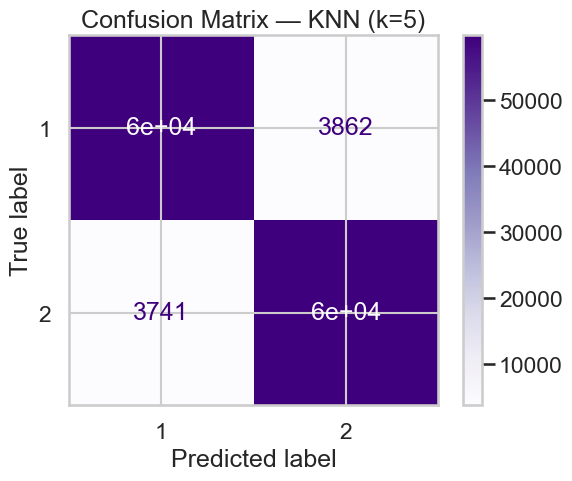

In [75]:
from sklearn.neighbors import KNeighborsClassifier

# -----------------------------
# Модель kNN с k=5
# -----------------------------
knn_model = KNeighborsClassifier(n_neighbors=5)

# Собираем тот же пайплайн (препроцессинг остаётся прежним)
knn_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("clf", knn_model)
    ]
)

# Обучаем на train, проверяем на test
knn_pipeline.fit(features_train, target_train)
knn_predictions = knn_pipeline.predict(features_test)

# Метрики
knn_accuracy = accuracy_score(target_test, knn_predictions)
knn_f1_macro = f1_score(target_test, knn_predictions, average="macro")

print("\n=== РЕЗУЛЬТАТЫ KNN ===")
print("Accuracy (test):", round(knn_accuracy, 3))
print("F1-macro (test):", round(knn_f1_macro, 3))
print("\nОтчёт по классам (classification_report):\n")
print(classification_report(target_test, knn_predictions, digits=3))

# Матрица ошибок
ConfusionMatrixDisplay.from_predictions(target_test, knn_predictions, cmap="Purples")
plt.title("Confusion Matrix — KNN (k=5)")
plt.show()


# 🏠 Домашнее задание

Цель: закрепить практические шаги машинного обучения на другом датасете.

---

## Шаг 1. Выбор датасета
Выберите один из табличных датасетов с Hugging Face (или другой похожий источник):

- [`SIH/palmer-penguins`](https://huggingface.co/datasets/SIH/palmer-penguins) (тот, что на практике — можно повторить с другими моделями)
- [`inria-soda/tabular-benchmark`](https://huggingface.co/datasets/polinaeterna/tabular-benchmark) — сборник простых табличных задач  
- [`imodels/multitask-tabular-datasets`](https://huggingface.co/datasets/imodels/multitask-tabular-datasets) — несколько разных классификаций в одном  
- (по желанию) любой маленький датасет из Hugging Face Datasets Hub  

---

## Шаг 2. Подготовка
1. Загрузите датасет через `datasets.load_dataset`.  
2. Сформулируйте задачу (что будем предсказывать).  
3. Проведите EDA: размеры, признаки, пропуски, распределение классов, графики.  
4. Обработайте данные: импутация, кодирование категорий, масштабирование числовых.

---

## Шаг 3. Модели
1. Обучите **Logistic Regression** (как в практике).  
2. Обучите ещё одну модель на выбор:
   - KNN (`KNeighborsClassifier`). Кроме пингвинов
   - Decision Tree (`DecisionTreeClassifier`)  
   - Random Forest (`RandomForestClassifier`)  
3. Сравните их результаты.

---

## Шаг 4. Оценка качества
- Выведите **accuracy** и **F1-macro**.  
- Постройте **confusion matrix**.  
- Выведите `classification_report` и объясните словами:  
  * какие классы лучше предсказываются?  
  * какие путаются?  

---

## Шаг 5. Эксперименты
1. Попробуйте изменить параметры модели (например, `k` в KNN, `max_depth` у дерева).  
2. Попробуйте убрать один признак (feature) и посмотреть, изменилось ли качество.  
3. (по желанию) Добавьте кросс-валидацию (`cross_val_score`).

---

## Шаг 6. Итог
Сделайте вывод в свободной форме:
- какая модель лучше работает для выбранного датасета?  
- какие признаки оказались важными?  
- какие ошибки модель чаще всего делает?  
- доп. балл за кросс-валидацию, если сможете реализовать и представить итоги по ее работе)